# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. Get the Bragg disks
3. **Calibrate**
4. Calculate lattice vectors
5. Fit lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 3: Calibrate

In this step the necessary calibrations are performed.  This includes:

1. Measuring and correcting the relative shifts of the diffraction patterns due to the scanning of the beam
2. Measuring and correcting elliptical distortion of the diffraction patterns
3. Measuring the detector pixel size

### Import packages, load data

In [2]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
from time import time
from scipy.ndimage.filters import gaussian_filter

from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

# i/o
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import FileBrowser, read, append

# Diffraction shift correction
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.process.calibration import get_diffraction_shifts, find_outlier_shifts, shift_braggpeaks
from py4DSTEM.process.fit import fit_2D
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map

# Elliptical distortion correction
from py4DSTEM.process.utils import radial_integral, get_maxima_1D
from py4DSTEM.process.calibration import measure_elliptical_distortion, correct_elliptical_distortion, constrain_degenerate_ellipse

In [3]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
#fp = "/Users/Ben/Work/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    braggvectormap_uncorrected          DiffractionSlice    
   2    probe                               DiffractionSlice    
   3    braggpeaks                          PointListArray      


In [4]:
# Load data

dc = browser.get_dataobject('datacube')
braggpeaks_uncorrected = browser.get_dataobject('braggpeaks')
braggvectormap_uncorrected = browser.get_dataobject('braggvectormap_uncorrected').data
browser.close()

### 1. Diffraction shifts

Here we measure and correct shifts of the diffraction patterns due to the scanning of the beam in real space.  We proceed as follows:

Measure diffraction shifts
- Get an initial guess at the diffraction shifts
- Find outliers in initial diffraction shift guesses
- Ignoring outliers, fit a plane or parabola to the initial guess.

Correct diffraction shifts
- Apply shifts to the Bragg peak positions

#### Measure diffraction shifts

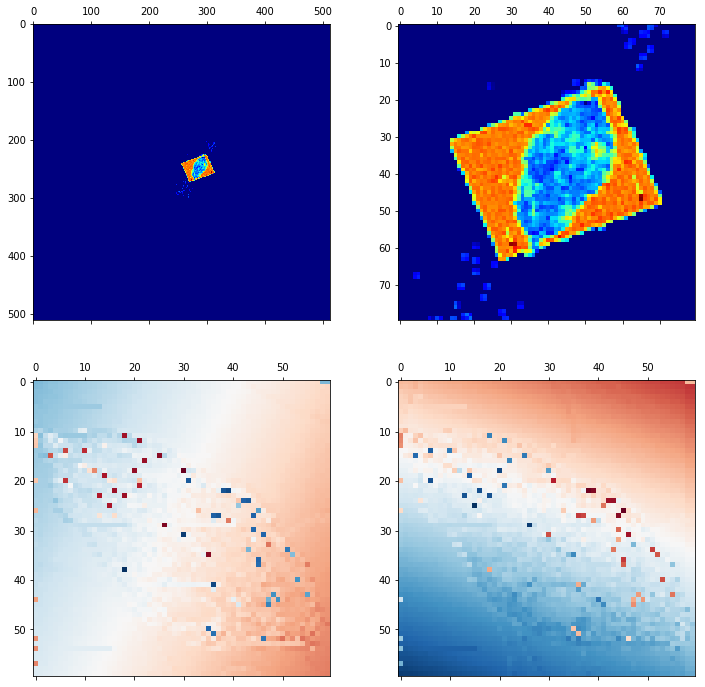

In [5]:
# Get diffraction shifts

findcenter = 'CoM'   # Must be 'CoM' or 'max'
rad = 40             # for display
power = 0.25

xshifts, yshifts, braggvectormap_center = get_diffraction_shifts(braggpeaks_uncorrected,
                                                                 dc.Q_Nx, dc.Q_Ny,
                                                                 findcenter=findcenter)

# Show
x0,y0 = py4DSTEM.process.utils.get_CoM(braggvectormap_center)

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(braggvectormap_center**0.25,cmap='jet')
ax12.matshow(braggvectormap_center[int(x0-rad):int(x0+rad),int(y0-rad):int(y0+rad)]**power,cmap='jet')
ax21.matshow(xshifts,cmap="RdBu")
ax22.matshow(yshifts,cmap="RdBu")
plt.show()

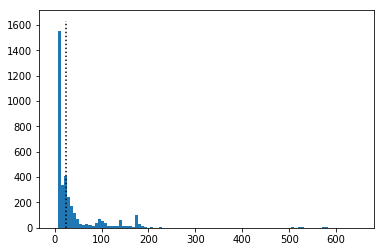

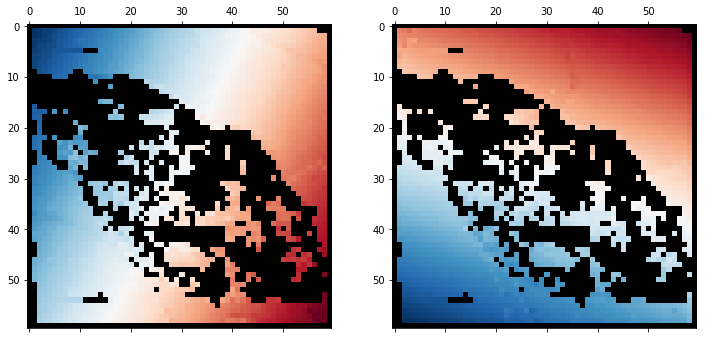

In [6]:
# Find outliers

n_sigma = 10
edge_boundary = 1
n_bins = 100

mask,n,bins,cutoff = find_outlier_shifts(xshifts,yshifts,n_sigma=n_sigma,edge_boundary=edge_boundary,n_bins=n_bins)

# Show
xshifts_masked = np.ma.masked_array(xshifts, mask)
yshifts_masked = np.ma.masked_array(yshifts, mask)
mask_display = np.ma.masked_array(mask, mask==False)

fig,ax = plt.subplots()
ax.bar(bins[:-1]+(bins[1]-bins[0])/2., n, (bins[1]-bins[0]), align='center')
ax.vlines(cutoff,0,ax.get_ylim()[1],linestyle=':')
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(xshifts_masked,cmap="RdBu")
ax2.matshow(yshifts_masked,cmap="RdBu")
ax1.matshow(mask_display)
ax2.matshow(mask_display)
plt.show()

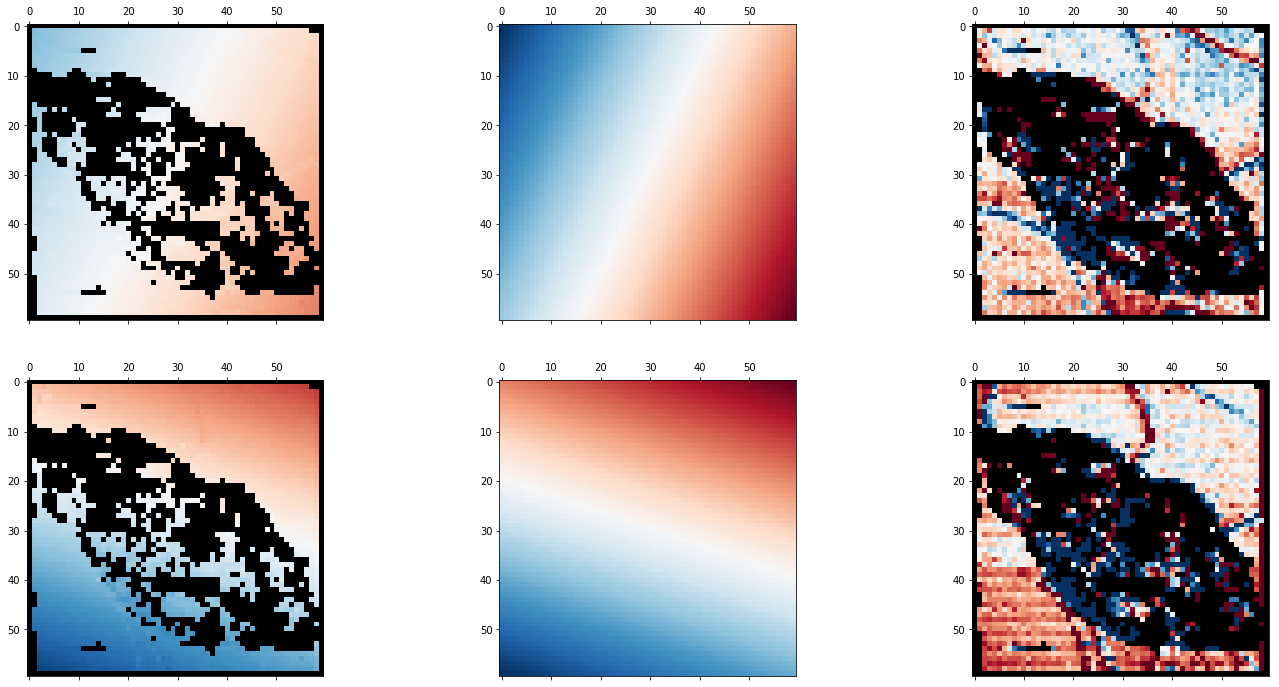

In [7]:
# Fit the diffraction shifts

fit_function = py4DSTEM.process.fit.plane        # Select fit type
#fit_function = py4DSTEM.process.fit.parabola

# Fit
xshifts_fit = np.zeros_like(xshifts)
yshifts_fit = np.zeros_like(yshifts)
popt_x, pcov_x, xshifts_fit = fit_2D(fit_function, xshifts, data_mask=mask==False)
popt_y, pcov_y, yshifts_fit = fit_2D(fit_function, yshifts, data_mask=mask==False)
residuals_x = xshifts-xshifts_fit
residuals_y = yshifts-yshifts_fit
residuals_x[mask] = 0
residuals_y[mask] = 0

# Show
fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,12))
ax11.matshow(xshifts,cmap="RdBu")
ax21.matshow(yshifts,cmap="RdBu")
ax12.matshow(xshifts_fit,cmap="RdBu")
ax22.matshow(yshifts_fit,cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
ax11.matshow(mask_display)
ax21.matshow(mask_display)
ax13.matshow(mask_display)
ax23.matshow(mask_display)
plt.show()

#### Correct diffraction shifts

In [8]:
# Apply shifts

braggpeaks_shiftcorrected = shift_braggpeaks(braggpeaks_uncorrected, xshifts_fit, yshifts_fit)

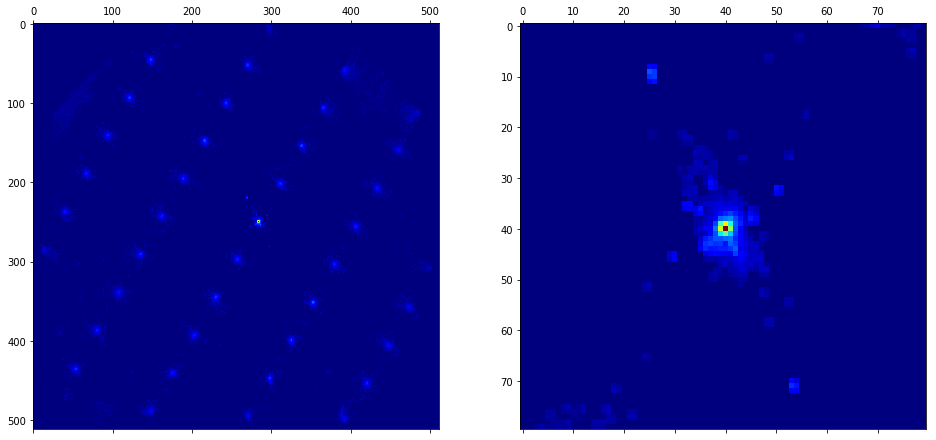

In [9]:
# Re-calculate Bragg vector map and show

braggvectormap_shiftcorrected = get_bragg_vector_map(braggpeaks_shiftcorrected,dc.Q_Nx,dc.Q_Ny)
power = 0.25

# Show
x0,y0=np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,8))
ax1.matshow(braggvectormap_shiftcorrected**0.25,cmap='jet')
ax2.matshow(braggvectormap_shiftcorrected[x0-rad:x0+rad,y0-rad:y0+rad]**power,cmap='jet')
plt.show()

### 2. Elliptical distortion

Here we measure and correct elliptical distortion of the diffraction patterns due to imperfect electron optics.  We proceed as follows:

- Fit an initial ellipse to an annular region of the Bragg vector map
- Constrain the resulting degenerate ellipse using a known angle between the fitting Bragg peaks
- Correct the elliptical distortions
- Measure final, corrected elliptical distortions

More details are found in notebooks/module_demos/calibration/ellipticaldistortion.ipynb and notebooks/module_demos/calibration/ellipticaldistortion_crystalline.ipynb.

#### Fit initial ellipse

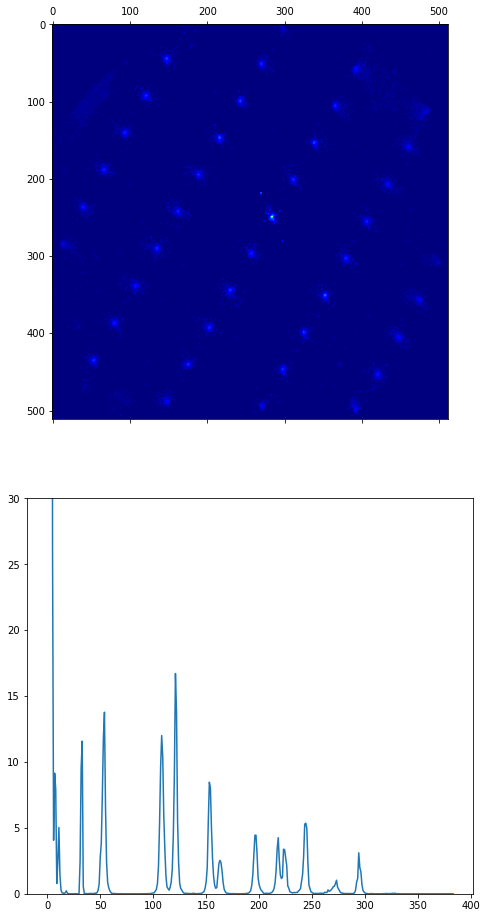

In [10]:
# Show Bragg vector map, calculate radial integral

ymax=30
power=0.25

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_shiftcorrected,2)),(dc.Q_Nx,dc.Q_Ny))
radial_profile = radial_integral(braggvectormap_shiftcorrected,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

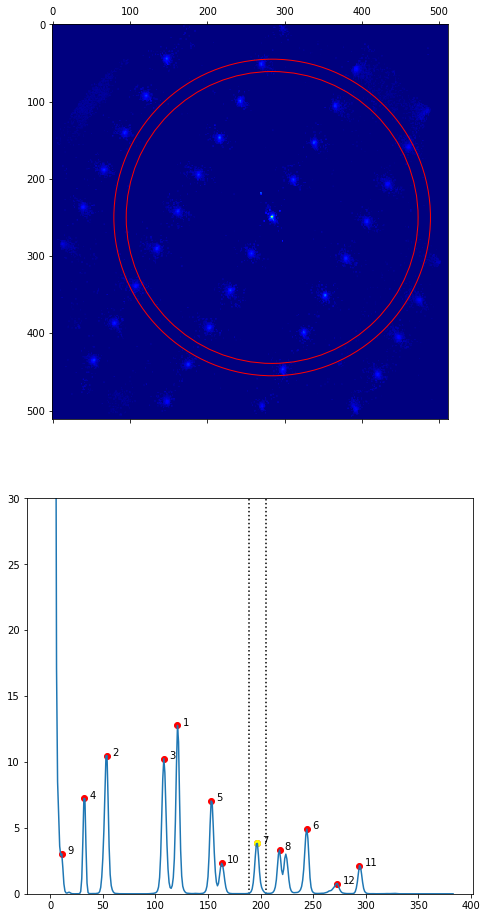

In [11]:
# Specify annular fitting region
# Get annulus center from selected radial profile maximum, specify annulus width

##### Parameters #####
# Find maxima
sigma = 1
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum and annulus width
selected_index = 7
annulus_width = 16

# Display params
ymax=30
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

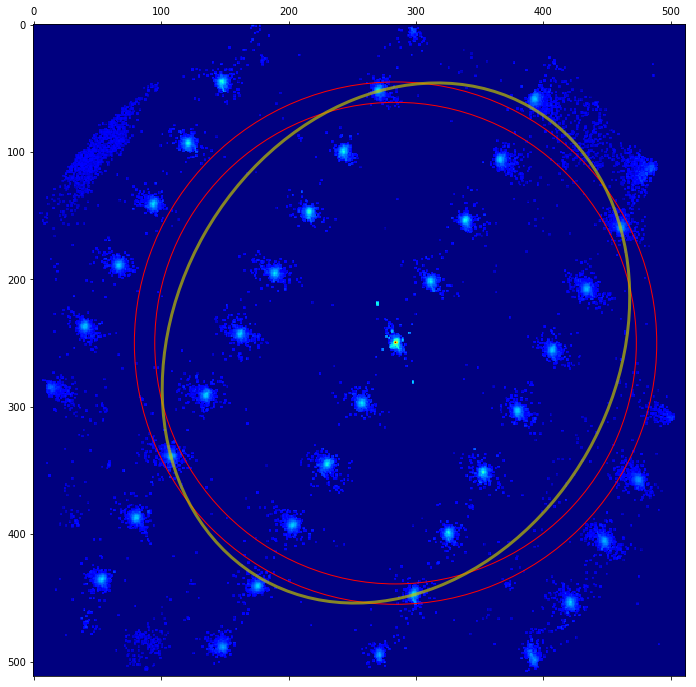

In [12]:
# Measure elliptical distortion

power = 0.15

# Measure with no mask
ellipse_params,_ = measure_elliptical_distortion(braggvectormap_shiftcorrected, x0, y0, r_inner, r_outer)
x,y,a,b,theta = ellipse_params

# Measure with a mask
# mask = np.ones_like(braggvectormap_shiftcorrected,dtype=bool)
# mask[:,int(y0-10):int(y0+10)] = False
# ellipse_params,_ = measure_elliptical_distortion(braggvectormap, x0, y0, r_inner, r_outer, mask)
# x,y,a,b,theta = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y,x),2*a,2*b,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
plt.show()

#### Contrain degenerate ellipse using known angle

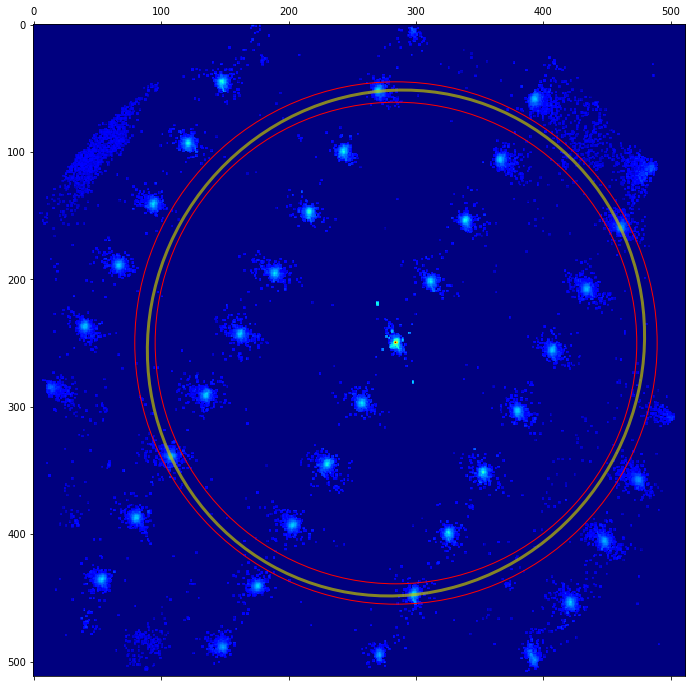

Measured elliptical distortion of 3.4%


In [13]:
# Set known angle
phi_known = 68.8  # in degrees

# Get contrained ellipse
phi_known = np.radians(phi_known)
a_constrained, b_constrained = constrain_degenerate_ellipse(braggvectormap_shiftcorrected,x,y,a,b,theta,r_inner,r_outer,phi_known)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_shiftcorrected**power,cmap='jet')
circle_inner = Circle((y,x),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y,x),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ellipse = Ellipse((y,x),2*a_constrained,2*b_constrained,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical distortion of {:.3}%".format(100*(max(a_constrained,b_constrained)/min(a_constrained,b_constrained) - 1)))

#### Correct elliptical distortions

In [14]:
corrected_ellipse_params = [x,y,a_constrained,b_constrained,theta]
braggpeaks_ellipsecorrected = correct_elliptical_distortion(braggpeaks_shiftcorrected, corrected_ellipse_params)

#### Measure corrected elliptical distortions

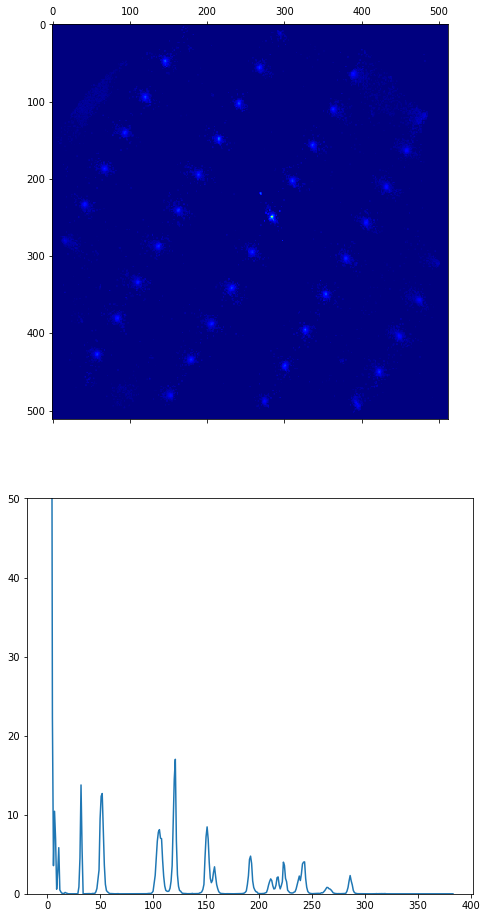

In [15]:
# Get new Bragg vector map and radial integral

ymax=50
power=0.25

braggvectormap_ellipsecorrected = get_bragg_vector_map(braggpeaks_ellipsecorrected,dc.Q_Nx,dc.Q_Ny)
x0,y0 = np.unravel_index(np.argmax(gaussian_filter(braggvectormap_ellipsecorrected,2)),(dc.Q_Nx,dc.Q_Ny))
radial_profile = radial_integral(braggvectormap_ellipsecorrected,x0,y0)[0]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,16))
ax1.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
ax2.plot(np.arange(len(radial_profile)),radial_profile)
ax2.set_ylim(0,ymax)
plt.show()

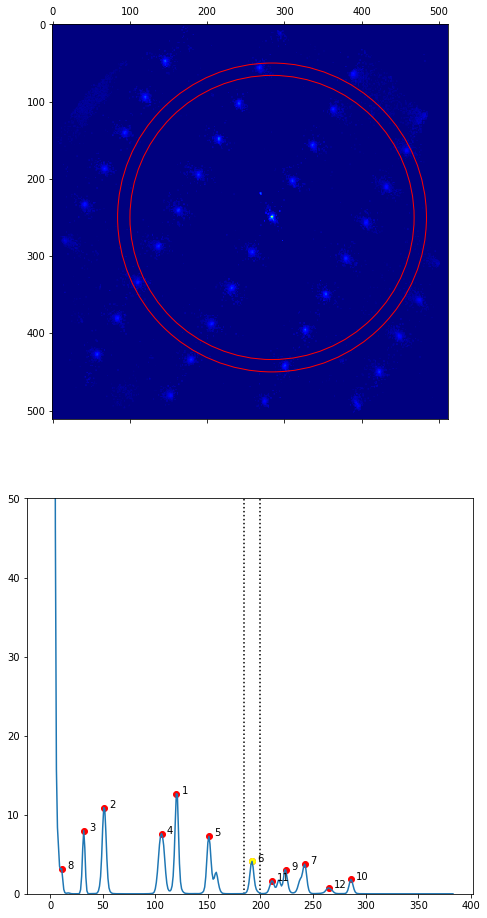

In [16]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 1
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 6
annulus_width = 16

# Display params
ymax=50
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,(ax2,ax1) = plt.subplots(2,1,figsize=(8,16))
ax1.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax1.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax1.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax1.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax1.vlines((r_inner,r_outer),0,ax1.get_ylim()[1],linestyle=":")
ax1.set_ylim(0,ymax)

ax2.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
circle_inner = Circle((y0,x0),radius=r_inner, fill=False, edgecolor='r', linestyle="-")
circle_outer = Circle((y0,x0),radius=r_outer, fill=False, edgecolor='r', linestyle="-")
ax2.add_patch(circle_inner)
ax2.add_patch(circle_outer)

plt.show()

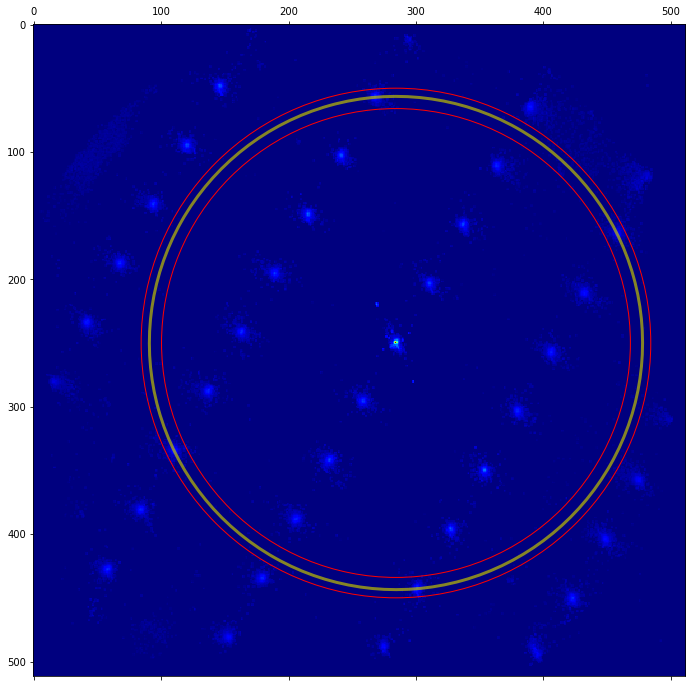

Measured elliptical distortion of 0.0107%


In [17]:
# Set known angle
phi_known = 68.8  # in degrees

# Get contrained ellipse
phi_known = np.radians(phi_known)
a_constrained, b_constrained = constrain_degenerate_ellipse(braggvectormap_ellipsecorrected,x,y,a,b,theta,r_inner,r_outer,phi_known)

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap_ellipsecorrected**power,cmap='jet')
circle_inner = Circle((y,x),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y,x),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ellipse = Ellipse((y,x),2*a_constrained,2*b_constrained,90-np.degrees(theta), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(ellipse)
plt.show()

print("Measured elliptical distortion of {:.3}%".format(100*(max(a_constrained,b_constrained)/min(a_constrained,b_constrained) - 1)))

### 3. Measure the Q pixel size

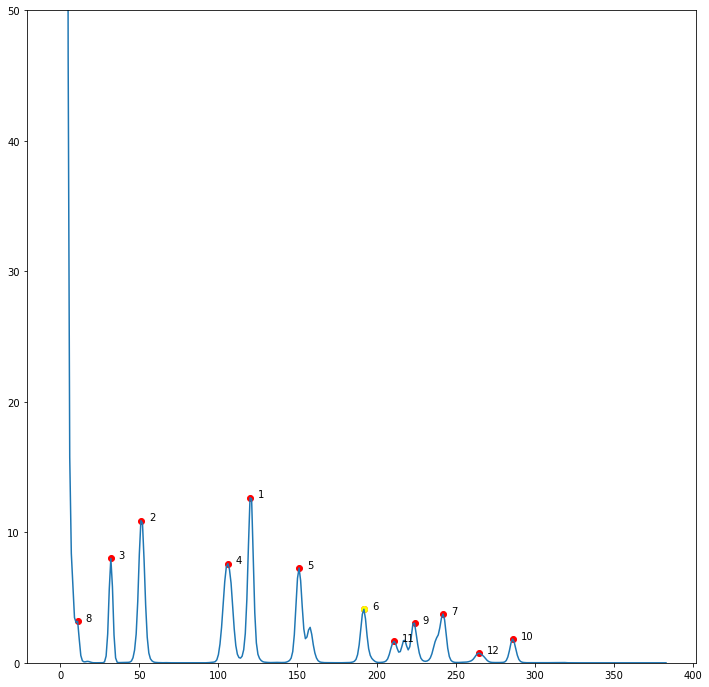

In [18]:
# Get radial profile maxima, and select one

##### Parameters #####
# Find maxima
sigma = 1
minSpacing = 10
minRelativeIntensity = 0.01
relativeToPeak = 1

# Select a maximum
selected_index = 6

# Display params
ymax=50
text_offset = 5
power = 0.25
#######################

maxima = get_maxima_1D(radial_profile, sigma=sigma, minSpacing=minSpacing,
                       minRelativeIntensity=minRelativeIntensity,
                       relativeToPeak=relativeToPeak)

r_peak = maxima[selected_index]
r_inner = r_peak - annulus_width/2.
r_outer = r_peak + annulus_width/2.

# Show
profile_smoothed = gaussian_filter(radial_profile,sigma)
fig,ax = plt.subplots(figsize=(12,12))
ax.plot(np.arange(len(profile_smoothed)),profile_smoothed)
ax.scatter(maxima,profile_smoothed[maxima],color='r')
for i in range(len(maxima)):
    if profile_smoothed[maxima[i]] < ymax:
        ax.text(maxima[i]+text_offset,profile_smoothed[maxima[i]],'{}'.format(i))
ax.scatter(r_peak,profile_smoothed[r_peak],color='yellow')
ax.set_ylim(0,ymax)
plt.show()

In [19]:
# Calibrate

d_spacing_invA = 5

invA_per_pixel = d_spacing_invA / maxima[selected_index]

### Save

In [20]:
# Store relevant data in  DataObjects

# Diffraction shifts
data = np.zeros((dc.R_Nx,dc.R_Ny,2))
data[:,:,0] = xshifts_fit
data[:,:,1] = yshifts_fit
diffractionshifts = RealSlice(data, slicelabels=('x_shifts','y_shifts'), name='diffraction_shifts')

# Corrected Bragg vector map
braggvectormap_corrected_diffslice = DiffractionSlice(braggvectormap_ellipsecorrected, name='braggvectormap_shiftcorrected_ellipsecorrected')

In [21]:
# Append to processing file

dataobjects = [diffractionshifts, braggvectormap_corrected_diffslice, braggpeaks_ellipsecorrected]

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(dataobjects, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.
